# Experiment 3 MobileNetV2

In [20]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

In [21]:
DATA_DIR = "/home/sagemaker-user/gesture-gaze-extension/datasets/ColumbiaGazeProcessed"
IMG_SIZE = (96, 96)
BATCH_SIZE = 32
NUM_CLASSES = len(os.listdir(os.path.join(DATA_DIR, 'train')))
BEST_MODEL_PATH = "/home/sagemaker-user/gesture-gaze-extension/models/mobilenetv2_gaze_best.keras"
LAST_MODEL_PATH = "/home/sagemaker-user/gesture-gaze-extension/models/mobilenetv2_gaze_last.keras"

train_dir = os.path.join(DATA_DIR, 'train')
val_dir = os.path.join(DATA_DIR, 'val')
test_dir = os.path.join(DATA_DIR, 'test')

class_names = sorted(os.listdir(train_dir))
class_indices = {name: idx for idx, name in enumerate(class_names)}

y_train = []
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    y_train.extend([class_indices[class_name]] * len(os.listdir(class_path)))

# Compute weights
class_weights_array = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights_array))

# Data Aug
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    brightness_range=[0.7, 1.3],
    zoom_range=0.1,
    horizontal_flip=True
).flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Checkpoints
callbacks = [
    ModelCheckpoint(
        BEST_MODEL_PATH,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),
    ModelCheckpoint(
        LAST_MODEL_PATH,
        save_best_only=False,
        save_weights_only=False,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True
    )
]

Found 4125 images belonging to 9 classes.
Found 912 images belonging to 9 classes.
Found 886 images belonging to 9 classes.


In [22]:
base_model = MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
base_model.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
# Train
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=100,
    callbacks=callbacks,
    class_weight=class_weights
)

/opt/conda/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.1570 - loss: 2.4686
Epoch 1: val_loss improved from inf to 2.54500, saving model to /home/sagemaker-user/gesture-gaze-extension/models/mobilenetv2_gaze_best.keras

Epoch 1: saving model to /home/sagemaker-user/gesture-gaze-extension/models/mobilenetv2_gaze_last.keras
129/129 ━━━━━━━━━━━━━━━━━━━━ 81s 443ms/step - accuracy: 0.1570 - loss: 2.4673 - val_accuracy: 0.1140 - val_loss: 2.5450
Epoch 2/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.2232 - loss: 1.9463
Epoch 2: val_loss did not improve from 2.54500

Epoch 2: saving model to /home/sagemaker-user/gesture-gaze-extension/models/mobilenetv2_gaze_last.keras
129/129 ━━━━━━━━━━━━━━━━━━━━ 55s 429ms/step - accuracy: 0.2233 - loss: 1.9460 - val_accuracy: 0.1480 - val_loss: 2.7953
Epoch 3/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.2861 - loss: 1.7323
Epoch 3: val_loss did not improve from 2.54500

Epoch 3: saving model to /home/sagemaker-user

In [24]:
# Evaluate
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.4f}")

28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.7781 - loss: 0.5794
Test Accuracy: 0.8386


In [25]:
best_model = tf.keras.models.load_model(BEST_MODEL_PATH)
last_model = tf.keras.models.load_model(LAST_MODEL_PATH)

In [26]:
model = best_model

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255).flow_from_directory(
    os.path.join(DATA_DIR, 'test'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Predict
y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_gen.classes
class_names = list(test_gen.class_indices.keys())

Found 886 images belonging to 9 classes.
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step


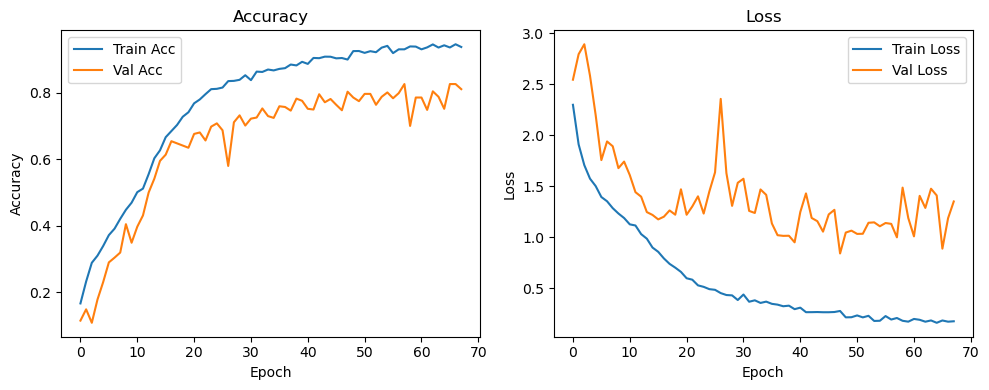

In [27]:
# 1. Plot training curves
def plot_training_curves(history):
    plt.figure(figsize=(10, 4))
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_training_curves(history)

In [28]:
# 2. Classification report
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
center,0.583333,0.651163,0.615385,43.0000
down,0.404255,0.452381,0.426966,42.0000
down_left,0.808511,0.883721,0.844444,129.0000
down_right,0.939655,0.865079,0.900826,126.0000
left,0.900826,0.865079,0.882591,126.0000
right,0.917355,0.880952,0.898785,126.0000
up,0.586957,0.642857,0.613636,42.0000
up_left,0.887218,0.936508,0.911197,126.0000
up_right,0.955752,0.857143,0.903766,126.0000
accuracy,0.838600,0.838600,0.838600,0.8386


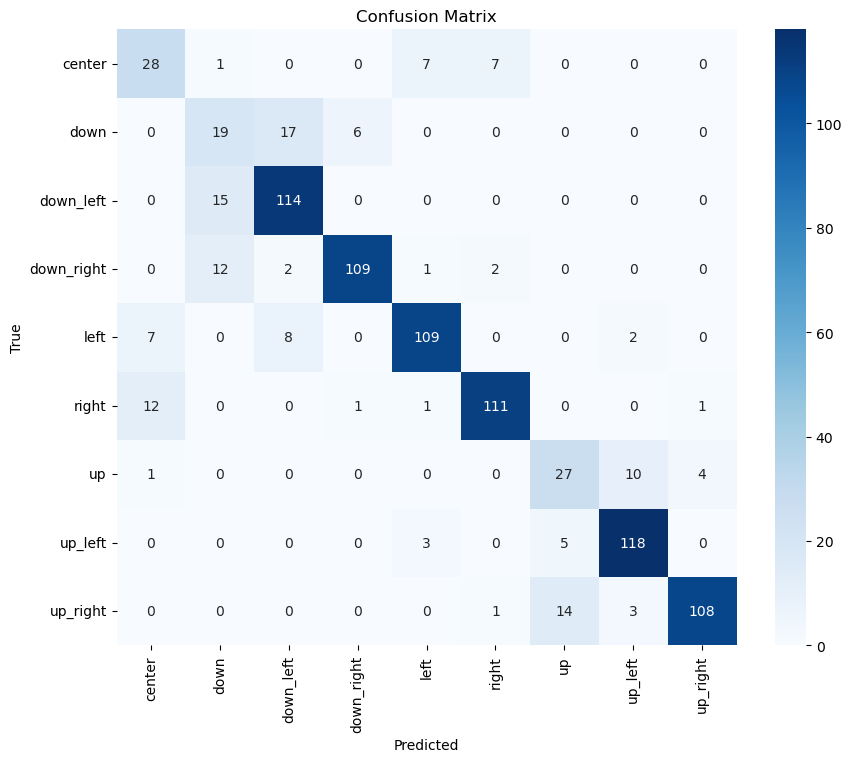

In [29]:
# 3. Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


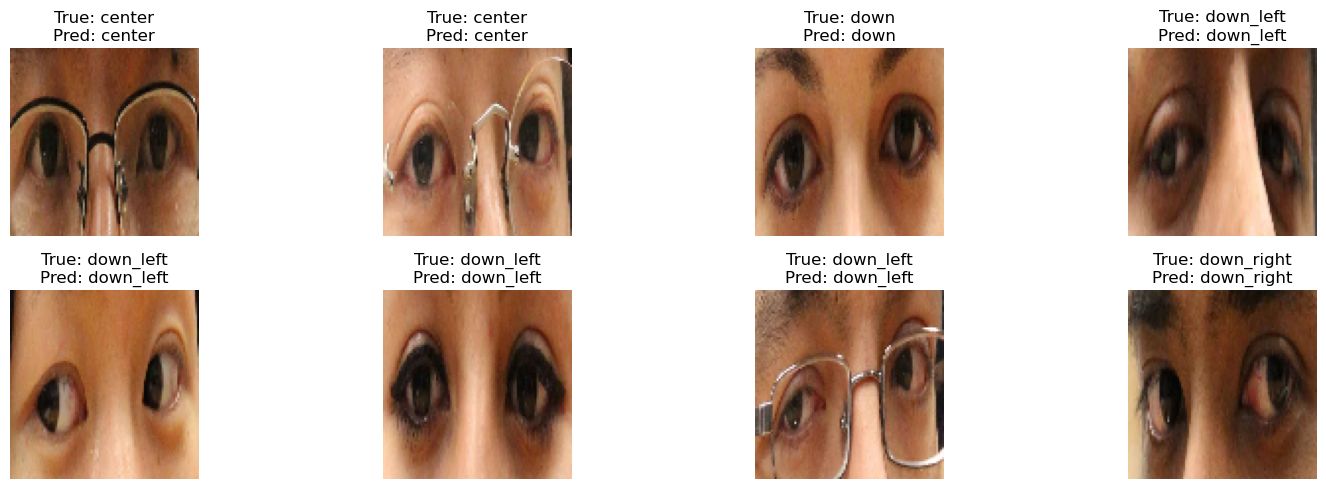

In [30]:
# 4. Inference examples
def plot_inference_examples(generator, y_pred, class_names, num_examples=8):
    fig, axes = plt.subplots(2, num_examples // 2, figsize=(16, 5))
    axes = axes.flatten()
    for i in range(num_examples):
        img, label = generator[i]
        pred_label = class_names[np.argmax(model.predict(np.expand_dims(img[0], axis=0)))]
        true_label = class_names[np.argmax(label[0])]
        axes[i].imshow(img[0])
        axes[i].set_title(f"True: {true_label}\nPred: {pred_label}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Display
plot_inference_examples(test_gen, y_pred, class_names)